# What is indexing?

An index fund is a type of mutual fund with a portfolio of stocks or bonds built by investment analysts that effectively generalizes the performance of the broader financial market, in this project we are working with NASDAQ-100. Indexing is a common passive investment strategy which involves building a long portfolio to replicate an index. However, tracking the index by holding all the stocks can be extremely costly due to transaction costs and performance costs from rebalancing. 

# Business importance of problem

From the above discussion, it follows that it is important to come up with a strategy for investors which maximizes their ability to track the index while factoring in the tradeoff of costs. To address this problem we developed two methods to determine the optimal selection of stocks and weights for the fund. This report will detail our mutual fund analytics team’s approach to formulate the methods, comparisons of results and evaluations to [our client’s name]. Our findings and recommendations formulate data-driven investment strategies that help [our client’s name] to achieve relatively lower costs with reasonably good profitability.

# Datasets used:

The datasets we used for our portfolio construction are daily prices of a total of N=100 index as well as component stocks of NASDAQ-100 in 2019. For testing purposes, we also utilized 2020 daily prices of the NASDAQ-100.

# Methods for Construction of Portfolio

## Method 1:

The first method can be summarized by the following sections:

* Construction of correlation matrix P through stock returns
* Select m out of N stocks to construct the portfolio
* Calculating portfolio weights to match the returns of the index as closely as possible
* Evaluate portfolio performance using new data and compare portfolio performance for different values of m (number of stocks in portfolio)

## Method 2:

The second method comprises of the following steps:
* Calculate stock returns
* Determine optimal portfolio weights by minimizing difference in returns
* Evaluate portfolio performance using new data and compare portfolio performance for different values of m

In [26]:
# Importing required libraries # Hide code
import gurobipy as gp
import pandas as pd
import numpy as np

In [27]:
# Ignoring warnings # Hide code
import warnings
warnings.filterwarnings('ignore')

# Part 1: Stock Selection

We first formulate an integer program to select a combination of stocks through maximizing the similarities between the chosen representatives and all the stocks in the fund.

Decision Variables:
* $y_{j}$ for j = 1 to N are binary variables that indicate whether or not stock j is selected to be in the fund
* $x_{ij}$ for i = 1 to N and j = 1 to N are binary variables that indicate whether or not stock j is the best representative of stock i of the NASDAQ-100 index

## Formulation of problem:

### Objective function:
Maximize similarities between stocks and their representatives (where is the correlation between stock i and j). The correlation matrix between the returns has been calculated in the code accordingly.

$$max_{x, y}\Sigma_{i=1}^{n}\Sigma_{j=1}^{n}\rho_{ij}x_{ij}$$

### Constraints

* Exactly m stocks have to be selected:

$$\Sigma_{j=1}^{n}y_{j}=m$$

* Each stock i has exactly one representative stock j in the fund:
$$\Sigma_{j=1}^{n}x_{ij}=1\:(i = 1, 2,..., n)$$

* Stock i is best represented by stock j only if stock j is in the portfolio (chosen set of stocks):

$$x_{ij}\leq y_{j} \: (i, j = 1, 2,..., n)$$
$$x_{ij}, y_{j} \in \{0, 1\}$$


In [28]:
def stock_selection(stocks_df_path, m):
    
    df = pd.read_csv(stocks_df_path)
    returns = df.set_index('X').pct_change()[1:]

    # Calculating the correlation matrix
    p = returns.drop(columns='NDX').corr().to_numpy()
    n_x = len(p.flatten())
    n_y = p.shape[0]

    obj = np.array(list(p.flatten()) + [0]*n_y)

    # For the sum of yj's should be = m, there is just one constraint here
    A = np.array([
        [0]*n_x + [1]*n_y
    ])

    # For the sum of Xij's = 1, there are n_y = n constraints here
    for i in range(n_y):
        B = np.array([0]*n_y*i + [1]*n_y + [0]*(n_x-n_y*i))
        A = np.vstack((A, B))

    # Logical constraint, there are n_x = n^2 constraints here. Could probably do this in the previous loop, separating for clarity
    for i in range(n_y):
        B = np.append(np.zeros((n_y, n_y*i)), np.eye(n_y), axis=1)
        B = np.append(B, np.zeros((n_y, n_x - n_y - n_y*i)), axis=1)
        C = np.array(-np.eye(n_y))
        BC = np.append(B, C, axis=1)
        A = np.vstack((A, BC))

    b = np.array([m] + [1]*n_y + [0]*n_x)
    sense = np.array(['='] + ['=']*n_y + ['<']*n_x)

    ipMod = gp.Model()
    ipMod_x = ipMod.addMVar(len(obj), vtype=['B']*len(obj)) 
    ipMod_con = ipMod.addMConstrs(A, ipMod_x, sense, b)
    ipMod.setMObjective(None, obj, 0, sense=gp.GRB.MAXIMIZE)

    ipMod.Params.OutputFlag = 0
    ipMod.optimize()
    
    result = ipMod_x.x
    best_stocks = np.array(df.columns[2:])[np.argwhere(result[-n_y:] == np.amax(result[-n_y:]))]
    return result[-n_y:], best_stocks

Here we show the selected stocks for m = 5. The first array shows the binary decision variables for y and the second array shows the names of the stocks corresponding to a non zero $y_{j}$.

In [29]:
stock_selection('stocks2019.csv', 5)

(array([-0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,
        -0.,  0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0., -0.,
        -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0.,  0.,  1., -0., -0.,  1., -0., -0., -0.,  1., -0.,
        -0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0., -0., -0.,
        -0., -0., -0.,  1., -0., -0., -0.,  1., -0.]),
 array([['LBTYK'],
        ['MXIM'],
        ['MSFT'],
        ['VRTX'],
        ['XEL']], dtype=object))

# Part 2.1: Portfolio Weights (Method - 1: Using Stock Selection)

After determining which stocks to include in our portfolio, we want to compute the weight of each stock to best match the returns of the index. To do this, we formed an optimization problem to minimize the difference between the return of the index and sum of the returns of our weighted stocks for all time periods. 

## Formulation of Problem:

### Decision variables:
* $d_{t}$ for t = the number of time indices in our returns dataframe. 
NOTE: Our $d_{t}$'s take the form:

$$d_{t} = q_{t} - \Sigma_{i=1}^{m}w_{i}r_{it}$$

* $w_{i}$ for i = 1 to m (how many stocks we are selecting).

### Objective function: 
Minimize difference in returns
$$min_{w}\Sigma_{t}^{n}d_{t}$$

### Constraints:
* Sum of all weights must be 1:
$$\Sigma_{i=1}^{m}w_{i}=1$$

* Each weight must be greater than or equal to 0:
$$w_{i} \geq 0$$

* Modulus constraints (since we are restricting to be the absolute value):

$$d_{t} + \Sigma_{i=1}^{m}w_{i}r_{it} \geq q_{t}\:for\: t=1,2,...,T$$
$$d_{t} - \Sigma_{i=1}^{m}w_{i}r_{it} \geq -q_{t}\:for\: t=1,2,...,T$$


In [30]:
def portfolio_weights(stocks_df_path, m):

    selections, best_stocks = stock_selection(stocks_df_path, m)
    df = pd.read_csv(stocks_df_path)
    returns = df.set_index('X').pct_change()[1:]
    
    # Getting the return of the index
    q = returns['NDX'].to_numpy()

    # Getting the returns of the selected stocks
    opt_returns = returns[best_stocks.T.tolist()[0]].to_numpy()

    times = len(q)
    b = []
    sense = []

    # There are as many d's as the number of times, and number of weights = m
    obj = np.array([1]*times + [0]*m)

    # For the sum of weights = 1
    A = np.array([
        [0]*times + [1]*m 
    ])

    sense += ['=']
    b += [1]

    # Modulus constraints, there are 2t constraints here
    B_plus = np.zeros(times + m)
    B_minus = np.zeros(times + m)
    for i in range(times):
        B_plus[i] = 1
        B_minus[i] = -1
        B_plus[times:] = opt_returns[i, :]
        B_minus[times:] = opt_returns[i, :]
        A = np.vstack((A, B_plus))
        sense += ['>']
        b += [q[i]]
        A = np.vstack((A, B_minus))
        sense += ['<']
        b += [q[i]]

    b = np.array(b)
    sense = np.array(sense)        

    ipMod = gp.Model()
    # lower bound is automatically set as 0
    ipMod_x = ipMod.addMVar(len(obj), vtype=['C']*len(obj)) 
    ipMod_con = ipMod.addMConstrs(A, ipMod_x, sense, b)
    ipMod.setMObjective(None, obj, 0, sense=gp.GRB.MINIMIZE)

    ipMod.Params.OutputFlag = 0
    ipMod.optimize()

    weights = ipMod_x.x[-m:]
    return weights

Here we show the weights obtained for selection of m=5 stocks on each of the stocks in order(stock array already shown above).

In [31]:
portfolio_weights('stocks2019.csv', 5)

array([0.14300823, 0.08847893, 0.49092332, 0.03181085, 0.24577868])

# Part 2.2: Portfolio weights (Method - 2: Ignoring stock selection)

Here we define our function for method - 2 (as explained above), where we ignore stock selection and directly obtain our weights. The problem formulation changes as follows to a mixed integer program. The only thing that changes here is that the number of weights to optimize over changes from m to n, and we define some extra binary variables $y_{j}$ to specify how many weights to select:

## Formulation of Problem:

### Decision variables:
* $d_{t}$ for t = the number of time indices in our returns dataframe. 
NOTE: Our $d_{t}$'s take the form:

$$d_{t} = q_{t} - \Sigma_{i=1}^{n}w_{i}r_{it}$$

* $w_{i}$ for i = 1 to n (total number of stocks). These are the weight variables.

* $y_{j}$ for j = 1 to n (total number of stocks). These binary variables force $w_{i}$ to be 0 when $y_{i}$ is 0.

### Objective function: 
Minimize difference in returns
$$min_{w}\Sigma_{t}^{n}d_{t}$$

### Constraints:
* Sum of all weights must be 1:
$$\Sigma_{i=1}^{m}w_{i}=1$$

* Sum of all $y_{i}$'s must be equal than m (the number of stocks to be selected)

$$\Sigma_{i=1}^{n}y_{i} = m$$

* $y_{i}$'s must be binary
$$y_{i} \in \{0, 1\}$$
* Each weight must be greater than or equal to 0:
$$w_{i} \geq 0$$

* Big M constraint: This states that $w_{i}$'s have to be 0 if the corresponding $y_{i}$'s are 0. The smallest value that M can take is 1, because the maximum value of any given weight is 1

$$w_{i} - My_{i} \leq 0 \: for\: i=1, 2,...n$$

* Modulus constraints (since we are restricting to be the absolute value):

$$d_{t} + \Sigma_{i=1}^{m}w_{i}r_{it} \geq q_{t}\:for\: t=1,2,...,T$$
$$d_{t} - \Sigma_{i=1}^{m}w_{i}r_{it} \geq -q_{t}\:for\: t=1,2,...,T$$

Since this is a very hard problem for Gurobi to solve, we add a time limit variable to stop execution of the program after 1 hr.


In [32]:
def portfolio_weights_2(stocks_df_path, m):

    # TIME LIMIT VARIABLE
    time_limit = 3600
    df = pd.read_csv(stocks_df_path)
    returns = df.set_index('X').pct_change()[1:]
    
    # Getting the return of the index
    q = returns['NDX'].to_numpy()

    # Getting the returns of all selected stocks
    returns = returns.drop(columns='NDX').to_numpy()

    n = returns.shape[1]
    times = len(q)
    b = []
    sense = []

    # There are as many d's as the number of times, number of weights and yj's = n
    obj = np.array([1]*times + [0]*n + [0]*n)

    # For the sum of all yj's = m and sum of weights = 1
    A = np.array([
        [0]*times + [0]*n + [1]*n,
        [0]*times + [1]*n + [0]*n
    ])

    sense += ['=', '=']
    b += [1, m]

    # Big M constraints, there are n constraints here
    # Smallest value M can take is 1
    M = 1

    B1 = np.zeros((n, times))
    B2 = np.eye(n)
    B3 = -M*np.eye(n)
    B = np.append(B1, B2, axis=1)
    B = np.append(B, B3, axis=1)
    A = np.vstack((A, B))
    sense += ['>']*n
    b += [0]*n

    # Modulus constraints, there are 2t constraints here
    B_plus = np.zeros(times + 2*n)
    B_minus = np.zeros(times + 2*n)
    for i in range(times):
        B_plus[i] = 1
        B_minus[i] = -1
        B_plus[(times + n):] = returns[i, :]
        B_minus[(times + n):] = returns[i, :]
        A = np.vstack((A, B_plus))
        sense += ['>']
        b += [q[i]]
        A = np.vstack((A, B_minus))
        sense += ['<']
        b += [q[i]]

    b = np.array(b)
    sense = np.array(sense)        

    ipMod = gp.Model()
    # lower bound is automatically set as 0
    ipMod_x = ipMod.addMVar(len(obj), vtype=['C']*times + ['B']*n + ['C']*n) 
    ipMod_con = ipMod.addMConstrs(A, ipMod_x, sense, b)
    ipMod.setMObjective(None, obj, 0, sense=gp.GRB.MINIMIZE)

    ipMod.Params.OutputFlag = 0
    ipMod.Params.TimeLimit = time_limit
    ipMod.optimize()

    weights = ipMod_x.x[-n:]
    return weights 

Here we show the weights calculated when 5 stocks are selected in our portfolio for method 2.

In [33]:
print(portfolio_weights_2('stocks2019.csv', 5))

[0.         0.         0.         0.         0.         0.
 0.10139982 0.         0.         0.18676629 0.         0.14785074
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.29475142 0.         0.26923173
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.    

# Part 3.1: Testing the performance (With method 1 of Portfolio weights)

From these two optimization routines, we have constructed our portfolio using 2019 data. We can now evaluate its performance by calculating how well it tracks the index in 2020.

To do this, we again calculate the absolute value of  sum of the difference between the return of the index, NASDAQ, and the sum of the returns of our weighted stocks for all time periods. However, this time we already have our optimal weights constructed with 2019 data, and we are using the 2020 data for the returns.

In [54]:
def performance_test(stocks_df_train, stocks_df_test, m_list, w_list, s_list):

    objectives = {}
    for m in m_list:
        
        # Getting the best stocks and the weights on the training data
        selections, best_stocks = stock_selection(stocks_df_train, m)
        s_list.append(best_stocks)
        weights = portfolio_weights(stocks_df_train, m)
        w_list.append(weights)

        # Loading the testing data
        df = pd.read_csv(stocks_df_test)

        # Getting returns
        returns = df.set_index('X').pct_change()[1:]
    
        # Getting the returns of the index
        q = returns['NDX'].to_numpy()

        # Getting the returns of the selected stocks
        opt_returns = returns[best_stocks.T.tolist()[0]].to_numpy()

        # Calculating the objective values for every m
        objective = np.sum(np.absolute(q - np.dot(weights, opt_returns.T)))
        objectives[m] = objective

    return objectives, w_list, s_list

In [55]:
# Out of sample performance
stock_list_out = []
n = input("Please enter the maximum number of stocks you want to select (NOTE: The number you select MUST be less than or equal to the total number of stocks)")
weight_list_out = []
objectives, weight_list_out, stock_list_out = performance_test('stocks2019.csv', 'stocks2020.csv', [5] + [10*i for i in range(1, int(int(n)/10))], weight_list_out, stock_list_out)

After such calculations, we see that the sum of this difference is as listed below for different number of stocks being selected in our portfolio for the out of sample data (2020 returns). 

In [56]:
# Hide code
for k, v in objectives.items():
    print(f"Out of sample objective value when {k} stocks are selected is {v}")

Out of sample objective value when 5 stocks are selected is 1.0579614661890795
Out of sample objective value when 10 stocks are selected is 1.2819989776630916
Out of sample objective value when 20 stocks are selected is 0.7280433003353786
Out of sample objective value when 30 stocks are selected is 0.6146189299557008
Out of sample objective value when 40 stocks are selected is 0.699585317569496
Out of sample objective value when 50 stocks are selected is 0.6663146147452426
Out of sample objective value when 60 stocks are selected is 1.0244696642780542
Out of sample objective value when 70 stocks are selected is 0.4331161039702177
Out of sample objective value when 80 stocks are selected is 0.4614843045815562
Out of sample objective value when 90 stocks are selected is 0.25908210437173046


In [57]:
# In sample performance # Hide code
stock_list_in = []
weight_list_in = []
objectives_in, weight_list_in, stock_list_in = performance_test('stocks2019.csv', 'stocks2019.csv', [5] + [10*i for i in range(1, int(int(n)/10))], weight_list_in, stock_list_in)

We have also evaluated in-sample performance, which is how closely our portfolio is matching the 2019 data, and comparing this to the out of sample performance, it seems lower, as expected (we are training our selection process on the 2019 data).

In [58]:
for k, v in objectives_in.items():
    print(f"In sample objective value when {k} stocks are selected is {v}")

In sample objective value when 5 stocks are selected is 1.0215100492765838
In sample objective value when 10 stocks are selected is 0.8494284705189007
In sample objective value when 20 stocks are selected is 0.6043506339765996
In sample objective value when 30 stocks are selected is 0.5829533712312525
In sample objective value when 40 stocks are selected is 0.4982990240821438
In sample objective value when 50 stocks are selected is 0.49641466319545124
In sample objective value when 60 stocks are selected is 0.45074770851994445
In sample objective value when 70 stocks are selected is 0.2575926231951873
In sample objective value when 80 stocks are selected is 0.22265988818698526
In sample objective value when 90 stocks are selected is 0.08119445578702068


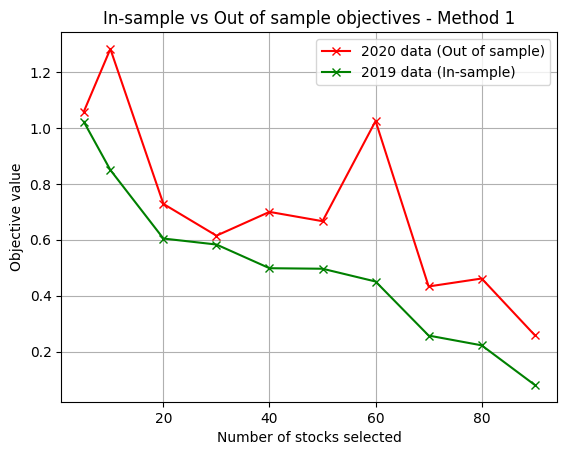

In [59]:
# Plotting objective values # Hide code
import matplotlib.pyplot as plt

plt.plot(objectives.keys(), objectives.values(), marker = 'x', color = 'red', label = '2020 data (Out of sample)')
plt.plot(objectives_in.keys(), objectives_in.values(), marker = 'x', color = 'green', label = '2019 data (In-sample)')
plt.title('In-sample vs Out of sample objectives - Method 1')
plt.legend(loc='best')
plt.xlabel('Number of stocks selected')
plt.ylabel('Objective value')
plt.grid()
plt.show()

# Part 3.2: Testing the performance (With method 2 of Portfolio weights)

Here we test performance of method 2 all all the stocks and calculate the objective values for the same values of number of selected stocks as above. 

In [16]:
import os
def performance_test_2(stocks_df_train, stocks_df_test, m_list, w_list):

    if stocks_df_train != stocks_df_test:
        if os.path.exists('results_method_2.csv'):
            return "Results file already exists, please load that"
        else: 
            objectives = {}
            for m in m_list:
                
                # Getting the best weights on the training data
                weights = portfolio_weights_2(stocks_df_train, m)
                w_list.append(weights)
                
                # Loading the testing data
                df = pd.read_csv(stocks_df_test)

                # Getting returns
                returns = df.set_index('X').pct_change()[1:]
            
                # Getting the returns of the index
                q = returns['NDX'].to_numpy()

                # Getting the returns of the selected stocks
                returns = returns.drop(columns='NDX').to_numpy()

                # Calculating the objective values for every m
                objective = np.sum(np.absolute(q - np.dot(weights, returns.T)))
                objectives[m] = objective

            df_results = pd.DataFrame(objectives, index=['Objective'])
            df_results.to_csv('results_method_2.csv')
            return objectives, w_list
    else:
        if os.path.exists('results_in_method_2.csv'):
            return "Results file already exists, please load that"
        else:
                objectives = {}
                for m in m_list:
                    
                    # Getting the best weights on the training data
                    weights = portfolio_weights_2(stocks_df_train, m)
                    w_list.append(weights)

                    # Loading the testing data
                    df = pd.read_csv(stocks_df_test)

                    # Getting returns
                    returns = df.set_index('X').pct_change()[1:]
                
                    # Getting the returns of the index
                    q = returns['NDX'].to_numpy()

                    # Getting the returns of the selected stocks
                    returns = returns.drop(columns='NDX').to_numpy()

                    # Calculating the objective values for every m
                    objective = np.sum(np.absolute(q - np.dot(weights, returns.T)))
                    objectives[m] = objective

                df_results = pd.DataFrame(objectives, index=['Objective'])
                df_results.to_csv('results_in_method_2.csv')
                return objectives, w_list


In [17]:
# Out of sample performance # Hide code
weight_list_out_2 = []
objectives, weight_list_out_2 = performance_test_2('stocks2019.csv', 'stocks2020.csv', [5] + [10*i for i in range(1, int(int(n)/10))], weight_list_out_2)

Here we list the objective values obtained on the out of sample testing values (2020 data)

In [18]:
for k, v in objectives.items():
    print(f"In sample objective value when {k} stocks are selected is {v}")

In sample objective value when 5 stocks are selected is 0.7684217459301446
In sample objective value when 10 stocks are selected is 0.4279350746609912
In sample objective value when 20 stocks are selected is 0.4238824369036571
In sample objective value when 30 stocks are selected is 0.3544270766701274
In sample objective value when 40 stocks are selected is 0.30566021727908627
In sample objective value when 50 stocks are selected is 0.28200955204750666
In sample objective value when 60 stocks are selected is 0.2639443975956725
In sample objective value when 70 stocks are selected is 0.26235699768711856
In sample objective value when 80 stocks are selected is 0.25996280567791646
In sample objective value when 90 stocks are selected is 0.25953387829221425


In [19]:
# In sample performance # Hide code
weight_list_in_2 = []
objectives_in, weight_list_in_2 = performance_test_2('stocks2019.csv', 'stocks2019.csv', [5] + [10*i for i in range(1, int(int(n)/10))], weight_list_in_2)

We have also evaluated in-sample performance, which is how closely our portfolio is matching the 2019 data, and comparing this to the out of sample performance, it seems lower, as expected (we are training our selection process on the 2019 data).

In [20]:
# Hide code
for k, v in objectives_in.items():
    print(f"In sample objective value when {k} stocks are selected is {v}")

In sample objective value when 5 stocks are selected is 0.6121767960782374
In sample objective value when 10 stocks are selected is 0.3506732128116635
In sample objective value when 20 stocks are selected is 0.22062518348087073
In sample objective value when 30 stocks are selected is 0.14200801031994115
In sample objective value when 40 stocks are selected is 0.11301457613532004
In sample objective value when 50 stocks are selected is 0.0844500555602633
In sample objective value when 60 stocks are selected is 0.07565679385772478
In sample objective value when 70 stocks are selected is 0.07288149622406087
In sample objective value when 80 stocks are selected is 0.06726486311275338
In sample objective value when 90 stocks are selected is 0.06719725456611508


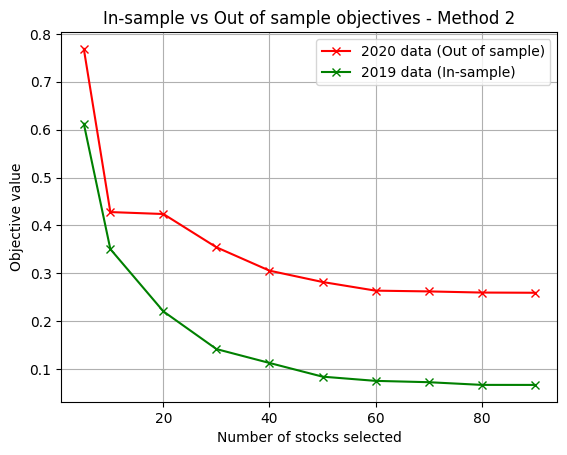

In [21]:
# Plotting objective values # Hide code
plt.plot(objectives.keys(), objectives.values(), marker = 'x', color = 'red', label = '2020 data (Out of sample)')
plt.plot(objectives_in.keys(), objectives_in.values(), marker = 'x', color = 'green', label = '2019 data (In-sample)')
plt.title('In-sample vs Out of sample objectives - Method 2')
plt.legend(loc='best')
plt.xlabel('Number of stocks selected')
plt.ylabel('Objective value')
plt.grid()
plt.show()

# Plotting the Weights of both methods

Here we compare the weights obtained by method 2 vs the weights obtained by method 1 for 3 samples of selected stocks (m=5, 10 and 20). We can see that the 1st method forces some stock's weights to be 0 at high values of m, whereas the second method allocates some weight (>0) for all selected stocks.

In [1]:
# Hide code
# Plotting the weights as a function of the stocks for method 1
m_list = [5] + [10*i for i in range(1, int(int(n)/10))]
fig, axs = plt.subplots(1, 3, sharey=True, constrained_layout=True)
for i in range(len(m_list[:3])):
    sample = '2019 data'

    # Weights, method 1
    axs[i].bar(list(stock_list_in[i].T[0]), list(weight_list_in[i]))
    axs[i].set_xticklabels(list(stock_list_in[i].T[0]), rotation=90)
    axs[i].title.set_text(f"m = {m_list[i]}")

fig.set_figheight(5)
fig.set_figwidth(18)
fig.suptitle("Weights and stocks of method 1", fontsize=20)
fig.text(0.5, -0.1,"The weights for both the in-sample (2019) and the out-of-sample (2020) are the same", ha='center')

NameError: name 'n' is not defined

Text(0.5, -0.1, 'The weights for both the in-sample (2019) and the out-of-sample (2020) are the same')

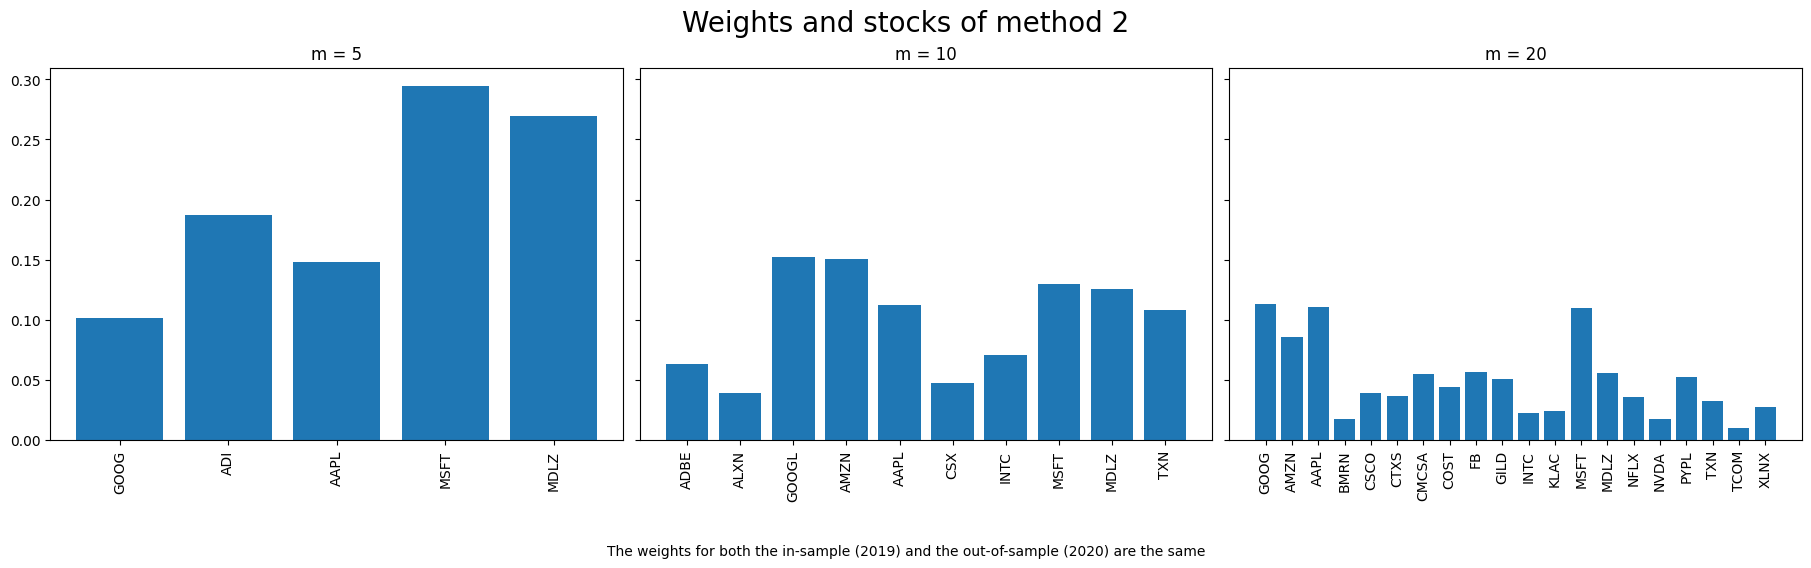

In [143]:
# Hide code
# Reloading the df
df = pd.read_csv('stocks2019.csv')

# Plotting the weights as a function of the stocks for method 2
fig, axs = plt.subplots(1, 3, sharey=True, constrained_layout=True)
for i in range(len(m_list[:3])):

    # Finding the stocks that correspond to the weights for in sample and out of sample
    stocks_in = list(np.array(df.columns[2:]).reshape((-1, 1))[np.argwhere(np.array(weight_list_in_2[i])!= 0)].T[0][0])
    stocks_out = list(np.array(df.columns[2:]).reshape((-1, 1))[np.argwhere(np.array(weight_list_out_2[i])!= 0)].T[0][0])

    # Weights, method 1
    axs[i].bar(stocks_in, list(weight_list_in_2[i][weight_list_in_2[i]!=0]))
    axs[i].set_xticklabels(stocks_in, rotation=90)
    axs[i].title.set_text(f"m = {m_list[i]}")

fig.set_figheight(5)
fig.set_figwidth(18)
fig.suptitle("Weights and stocks of method 2", fontsize=20)
fig.text(0.5, -0.1,"The weights for both the in-sample (2019) and the out-of-sample (2020) are the same", ha='center')

# Recommendations:

We now have two models for an index tracking strategy which we can present to our client. The first model is very computationally efficient, but a moderate improvement in tracking performance as more stocks are held in the portfolio. The second model, although requiring much greater computational power and time, the improvement in tracking performance is greater and more predictable (apparent from observing the objective values for both methods), especially from holding 5 stocks to holding 20 stocks. In both models, the increase in portfolio performance is accompanied by the costs of holding more stocks. If the client is looking to achieve the best performance of indexing with the least number of stocks, the second model is preferred and will pick 10 stocks to be held in the portfolio. If the client wants to rerun the model frequently, to see which stocks are the best representatives of the index, the first model is preferred and will pick 30 stocks to be held. Ultimately, the number of stocks to be held and their corresponding weights will depend on the client’s preferences. 